In [1]:
import numpy as np
import healpy as hp
import aipy as a
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
#import seaborn as sns
import scipy
from tqdm import tqdm
from scipy.signal import blackmanharris
import scipy.constants as const

%matplotlib notebook  

In [2]:
chans = range(203)
aa = a.cal.get_aa('psa6622_v004', .1/203, .1, 203)
freqs = aa.get_afreqs()

In [3]:
chan = 100
aa.select_chans(chan)
beamMap = a.map.Map(nside=32)
t3 = np.array(beamMap.px2crd(px = np.arange(beamMap.npix()),ncrd=3))
beamMap.map.map = aa[0].bm_response((t3[0],t3[1],t3[2]), pol='x')[0]**2
beamMap.map.map[t3[2]<0] = 0

In [181]:
res = .01
xs, ys = np.meshgrid(np.arange(-1,1,res),np.arange(-1,1,res))
zs = np.abs(np.sqrt(1 - xs**2 - ys**2))
topocentric = (np.ravel(xs), np.ravel(ys), np.ravel(zs))
#beamProjection = 0.0*aa[0].bm_response(topocentric, pol='x')[0]**2+1
beamProjection = aa[0].bm_response(topocentric, pol='x')[0]**2
#beamProjection = np.exp(-(np.ravel(xs)**2 + np.ravel(ys)**2)/1.0) # makes it a gaussian just for testing

'''wn = 2*np.pi/(const.c/(freqs[chan]*1e9))
ap = 3
sinTheta = (1-np.ravel(zs)**2)**.5
beamProjection = (2*scipy.special.j1(wn*ap*sinTheta) / (wn*ap*sinTheta))**2
beamProjection[np.isnan(beamProjection)] = 1'''
#pixelBeam[pixelAzAlt[1] < 0] = 0



beamProjection[np.ravel(xs)**2 + np.ravel(ys)**2 >= 1] = 0
beamProjection = beamProjection.reshape((len(xs),len(ys)))
beamProjection = np.pad(beamProjection,(2*len(xs),2*len(ys)),'constant')

#beamProjection = beamProjection/2 + np.flipud(beamProjection.conj())/2

/Users/jsdillon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


<IPython.core.display.Javascript object>


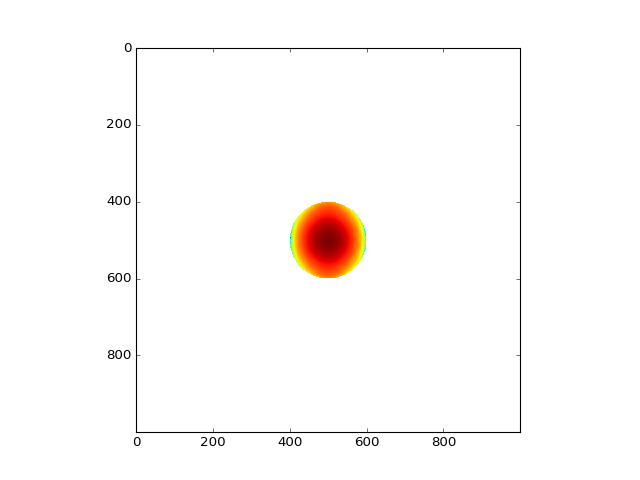

200


/Users/jsdillon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


In [182]:
plt.figure(1)
plt.imshow(np.log10(beamProjection),interpolation='none')
plt.show()
plt.grid(False)
print len(xs)

In [184]:
plt.figure(2)
plt.imshow((np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(beamProjection))))),interpolation='none')
plt.grid(False)

<IPython.core.display.Javascript object>


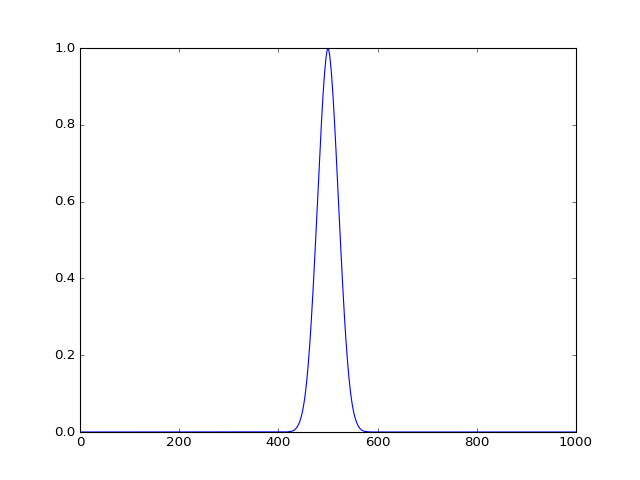

In [185]:
plt.figure(3);
beamCut = beamProjection[len(beamProjection)/2,:]
plt.plot(beamCut)

<IPython.core.display.Javascript object>


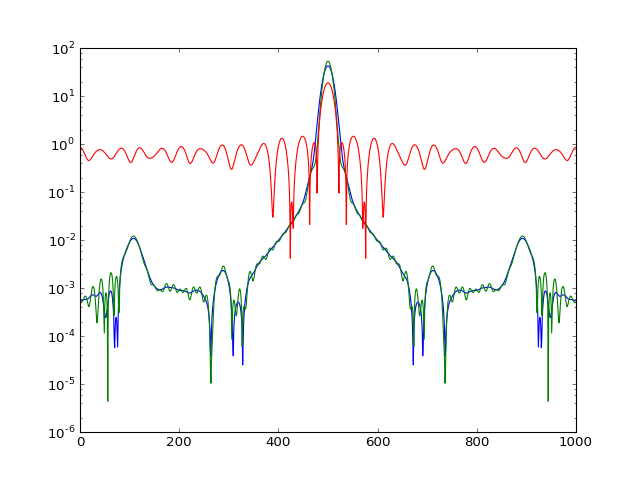

In [193]:
plt.figure(4)
from scipy.signal import blackmanharris
plt.semilogy(np.abs(np.fft.fftshift(np.fft.fft((np.pad(blackmanharris(200),400,'edge') * beamCut)))))
plt.semilogy(np.abs(np.fft.fftshift(np.fft.fft((beamCut)))))
#plt.semilogy(np.abs(np.fft.fftshift(np.fft.fft(np.exp(-(np.arange(1000)-500)**2/300)))))
plt.semilogy(np.abs(np.fft.fftshift(np.fft.fft(np.exp(-(np.arange(1000)-500)**2/600)*(np.pad(blackmanharris(200),400,'edge'))))))

<IPython.core.display.Javascript object>


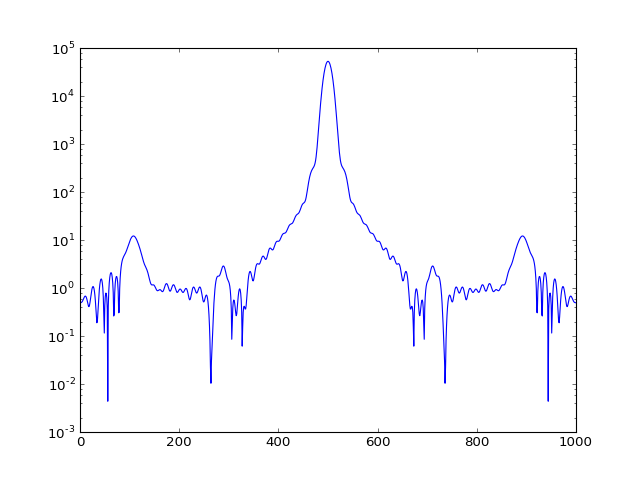

In [194]:
plt.figure(10)
plt.semilogy(np.abs(np.sum(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(beamProjection))),axis=0)))


In [195]:
# wavelength = 1.0/3.0
# b = 1.0
# plt.figure(10)
# plt.plot(np.arange(-1,1,.01), [np.real(np.exp(-2.0j * np.pi * s*b/wavelength)) for s in np.arange(-1,1,.01)])

In [196]:
oneDBeam1 = np.fft.fftshift(np.fft.fft(np.fft.fftshift(beamCut)))
oneDBeam2 = np.mean(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(beamProjection))),axis=0)

<IPython.core.display.Javascript object>


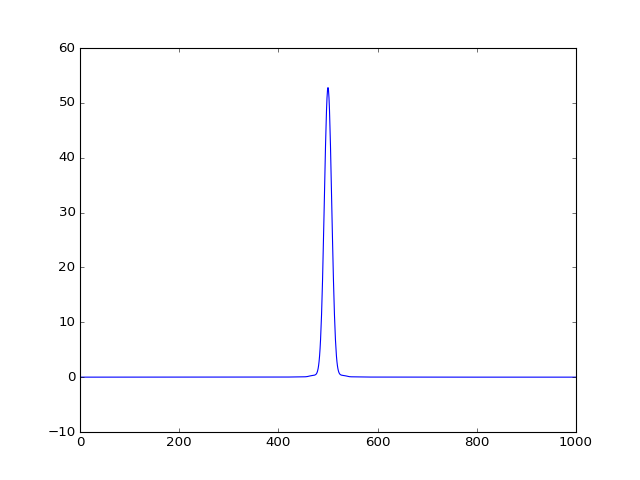

In [197]:
plt.figure(101);
#plt.plot(np.imag(oneDBeam1))
plt.plot((np.real(oneDBeam1)))
#plt.semilogy(np.abs(oneDBeam2))

In [198]:
1/np.pi

0.3183098861837907

<IPython.core.display.Javascript object>


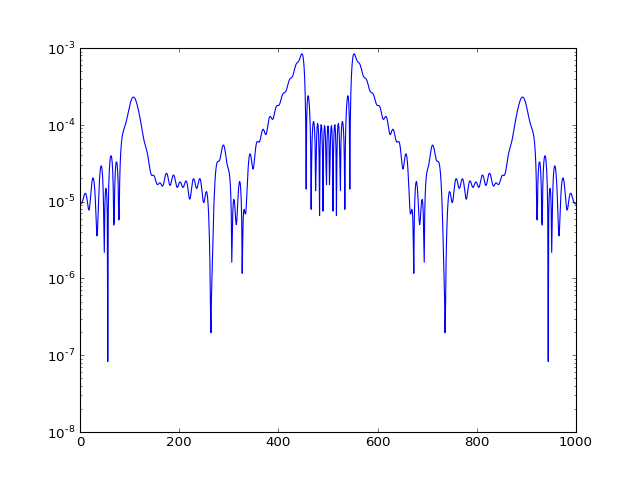

In [199]:


def beamFunc(u, std, hermCoeffs):
    allHermCoeffs = np.ravel(np.column_stack((hermCoeffs,np.zeros(len(hermCoeffs)))))
    return np.polynomial.hermite.hermval(u/std,allHermCoeffs) * np.exp(-u**2/std**2)

def errorFunc(beamParams, us, toFit):
    return np.abs(beamFunc(us, beamParams[0], beamParams[1:])[np.abs(beamCut)>0] - toFit[np.abs(beamCut)>0])
    
    

    
us = np.arange(-1,1, 2.0/len(oneDBeam1))


fit = np.asarray(scipy.optimize.leastsq(errorFunc, [1,1] +4*[0], args=(us,np.real(oneDBeam1)),ftol=1e-8)[0])


#popt, pcov = scipy.optimize.curve_fit(beamFunc, us, np.real(oneDBeam1))#, p0=([1,0,0,0], .1))

beamModel = beamFunc(us, fit[0], fit[1:])
plt.figure(7)
#plt.plot(us,beamModel)
#plt.plot(us,np.real(oneDBeam1))
#plt.plot(us,np.log10(np.abs(np.real(oneDBeam1))))
#plt.plot(us,np.log10(np.abs(beamModel)))
plt.semilogy(np.abs(beamModel - np.real(oneDBeam1))/np.max(np.real(oneDBeam1)))

<IPython.core.display.Javascript object>


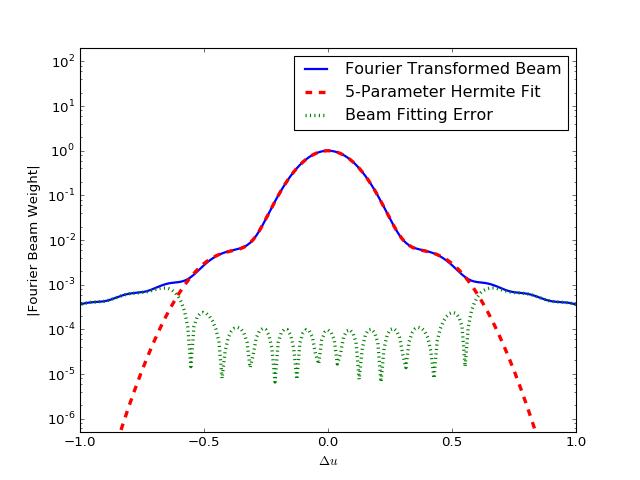

In [201]:
plt.figure(22222)
deltaus = (np.arange(len(oneDBeam1))-len(oneDBeam1)/2.0)/(len(oneDBeam1)/2.0)*2*np.pi

plt.semilogy(deltaus,np.abs(oneDBeam1)/np.max(np.abs(beamModel)),lw=2)
plt.semilogy(deltaus,np.abs(beamModel)/np.max(np.abs(beamModel)),'r--', lw=3)
plt.semilogy(deltaus,np.abs(oneDBeam1-beamModel)/np.max(np.abs(beamModel)),'g:',lw=3)
plt.xlim([-1,1])
plt.ylim([.5e-6,2e2])
plt.ylabel('|Fourier Beam Weight|')
plt.xlabel('$\Delta u$')
plt.legend(['Fourier Transformed Beam','5-Parameter Hermite Fit','Beam Fitting Error'])
plt.savefig('/Users/jsdillon/Documents/Presentations and Talks/Conferences/2017 URSI/BeamFitting.pdf',bbox_inches='tight')

In [178]:
allBeamCuts = []
allOneDBeams = []

for chan in tqdm(np.arange(0,203,1)): 
#    aa.select_chans(chan)
    beamMap = a.map.Map(nside=32)
    res = .01
    xs, ys = np.meshgrid(np.arange(-1,1,res),np.arange(-1,1,res))
    zs = np.abs(np.sqrt(1 - xs**2 + ys**2))
    topocentric = (np.ravel(xs), np.ravel(ys), np.ravel(zs))
#    beamProjection = aa[0].bm_response(topocentric, pol='y')[0]**2
    beamProjection = np.exp(-(np.ravel(xs)**2 + np.ravel(ys)**2)/.1/(freqs[chan]/.15)**2) # makes it a gaussian just for testing
    
    """wn = 2*np.pi/(const.c/(freqs[chan]*1e9))
    ap = 3
    sinTheta = (1-np.ravel(zs)**2)**.5
    beamProjection = (2*scipy.special.j1(wn*ap*sinTheta) / (wn*ap*sinTheta))**2
    beamProjection[np.isnan(beamProjection)] = 1"""
    #pixelBeam[pixelAzAlt[1] < 0] = 0

    beamProjection[np.ravel(xs)**2 + np.ravel(ys)**2 >= 1] = 0
    beamProjection = beamProjection.reshape((len(xs),len(ys)))
    beamProjection = np.pad(beamProjection,(2*len(xs),2*len(ys)),'constant')
    beamCut = beamProjection[len(beamProjection)/2,:]
    allBeamCuts.append(beamCut)
#    oneDBeam1 = np.fft.fftshift(np.fft.fft(np.fft.fftshift(np.pad(blackmanharris(200),400,'edge') * beamCut)))
    oneDBeam1 = np.fft.fftshift(np.fft.fft(np.fft.fftshift(beamCut)))
    allOneDBeams.append(oneDBeam1)


100%|██████████| 203/203 [00:01<00:00, 173.69it/s]


In [ ]:
allFits = []
allErrors = []

for oneDBeam1 in tqdm(allOneDBeams): 

    def errorFunc(beamParams, us, toFit):
        return np.abs(beamFunc(us, beamParams[0], beamParams[1:])[np.abs(beamCut)>0] - toFit[np.abs(beamCut)>0])

    def beamFunc(u, std, hermCoeffs):
        allHermCoeffs = np.ravel(np.column_stack((hermCoeffs,np.zeros(len(hermCoeffs)))))
        return np.polynomial.hermite.hermval(u/std,allHermCoeffs) * np.exp(-u**2/std**2)

    us = np.arange(-1,1, 2.0/len(oneDBeam1))
    guess = [.01,1] +0*[0]
    if len(allFits)>0: guess = allFits[-1]
    fit = np.asarray(scipy.optimize.leastsq(errorFunc, guess, args=(us,np.real(oneDBeam1)),ftol=1e-8)[0])
    allFits.append(fit)
    
    beamModel = beamFunc(us, fit[0], fit[1:])
    allErrors.append(np.linalg.norm(beamModel - np.real(oneDBeam1)) / np.linalg.norm(np.real(oneDBeam1)))
    
allFits = np.asarray(allFits)

In [ ]:
plt.figure(99)
plt.plot(allFits/np.mean(allFits,axis=0))
plt.legend(['Width'] + ['H'+str(n*2) for n in range(50)])

In [ ]:
plt.figure(9990);
term = 0
plt.plot(allFits[:,term],'.')
plt.plot(np.polyval(np.polyfit(range(203), allFits[:,term], 6), range(203)))

In [ ]:
plt.figure(2231)
plt.semilogy(allErrors)
#plt.legend(['Max order = H'+str(n*2) for n in range(50)])

In [ ]:
plt.figure(12322)
plt.plot(np.log10(np.asarray(allBeamCuts))[100:-1:10,400:600].T)
plt.legend(['Channel '+str(n) for n in range(100,203,10)])
#plt.plot(np.asarray(allBeamCuts)[,:].T)

In [ ]:
import aipy as a, numpy as n, pylab as p, sys, optparse, re
from mpl_toolkits.basemap import Basemap
#from matplotlib import rc
#rc('text', usetex=True)

o = optparse.OptionParser()
o.set_usage('hmap2alms.py [options] *.hmap')
a.scripting.add_standard_options(o, pol=True)
o.set_description(__doc__)
o.add_option('--order', dest='order', type=int, default=7,
    help='Polynomial order to fit for each pixel vs. frequency.  Default 7')
o.add_option('--lmax', dest='lmax', type=int, default=8,
    help='LMAX parameter for fitting spherical harmonics. Default 8')
o.add_option('--mmax', dest='mmax', type=int, default=8,
    help='MMAX parameter for fitting spherical harmonics. Default 8')
o.add_option('--abssq', action='store_true',
    help='Takes the absolute value squared of the input beams. Appropriate for making power beams.')
opts,args = o.parse_args(['-p', 'xx', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_090.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_091.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_092.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_093.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_094.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_095.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_096.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_097.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_098.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_099.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_100.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_101.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_102.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_103.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_104.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_105.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_106.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_107.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_108.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_109.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_110.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_111.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_112.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_113.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_114.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_115.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_116.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_117.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_118.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_119.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_120.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_121.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_122.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_123.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_124.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_125.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_126.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_127.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_128.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_129.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_130.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_131.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_132.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_133.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_134.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_135.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_136.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_137.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_138.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_139.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_140.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_141.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_142.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_143.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_144.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_145.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_146.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_147.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_148.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_149.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_150.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_151.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_152.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_153.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_154.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_155.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_156.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_157.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_158.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_159.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_160.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_161.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_162.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_163.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_164.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_165.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_166.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_167.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_168.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_169.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_170.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_171.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_172.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_173.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_174.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_175.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_176.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_177.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_178.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_179.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_180.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_181.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_182.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_183.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_184.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_185.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_186.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_187.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_188.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_189.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_190.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_191.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_192.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_193.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_194.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_195.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_196.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_197.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_198.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_199.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_200.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_201.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_202.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_203.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_204.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_205.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_206.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_207.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_208.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_209.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_210.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_211.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_212.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_213.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_214.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_215.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_216.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_217.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_218.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_219.hmap', '/Users/jsdillon/Desktop/HERA/hera-cst/HP_paper/GX_paper_220.hmap', '--abssq', '--lmax', '20', '--mmax', '20'])
assert(len(args) > 0)

nplt = len(args)
RES = .01
SZ = (int(n.pi/2/RES), int(2*n.pi/RES)+2)
alt,az = n.indices(SZ)
alt = n.pi/2 - alt.astype(n.float) * RES
az = az.astype(n.float) * RES
px,py,pz = a.coord.azalt2top((az.flatten(), alt.flatten()))
bmap = Basemap(projection='ortho', lat_0=90, lon_0=180)
cx,cy = bmap(az * a.img.rad2deg, alt * a.img.rad2deg)

def plot_hmap(hmap, cnt, max=0, min=-2):
    p.subplot(3, nplt, cnt)
    hmap.set_interpol(True)
    data = hmap[px,py,pz]
    data = n.log10(data**2)
    data.shape = az.shape
    bmap.drawmapboundary()
    bmap.drawmeridians(n.arange(0,360,30))
    bmap.drawparallels(n.arange(0,90,10))
    step = (max - min) / 35.
    levels = n.arange(min-step, max+step, step)
    bmap.contourf(cx, cy, data, levels)

re_freq = re.compile(r'_(\d+)\.hmap$')
freqs = n.array([float(re_freq.search(f).groups()[0]) / 1e3 for f in args])
hmaps = []
dat = []
for i, filename in enumerate(args):
    print 'Reading', filename
    m = a.healpix.HealpixMap(fromfits=filename)
    if opts.abssq: m.map = n.abs(m.map)**2
    m.map = (m.map / m[0,0,1]).clip(0,1)
    if len(dat) == 0:
        x,y,z = m.px2crd(n.arange(m.map.size), ncrd=3)
        v = n.where(z > 0, 1, 0)
        x = x.compress(v)
        y = y.compress(v)
        z = z.compress(v)
    # Swap pol from file 
    if opts.pol == 'y': m[y,x,z] = m[x,y,z]
    # Mirror bottom to prevent sharp discontinuities at z=0
    #m[x,y,-z] = m[x,y,z]
    plot_hmap(m, i+1)
    p.title('%0.3f GHz' % freqs[i])
    hmaps.append(m)
    dat.append(m.map)
    nside = m.nside()
dat = n.array(dat)

# print 'Fitting polynomials in frequency at each pointing...'
# poly = []
# for i in range(dat.shape[1]):
#     poly.append(n.polyfit(freqs, dat[:,i], opts.order))
# poly = n.array(poly)

# print 'Creating Healpix maps of each polynomial coefficient'
# pmaps = []
# for i in range(opts.order+1):
#     pmap = a.healpix.HealpixMap(nside, scheme='RING')
#     pmap.map = poly[:,i]
#     pmap.set_interpol(True)
#     pmaps.append(pmap)

# print 'Computing spherical harmonic coefficients...'
# palms = [pmap.to_alm(opts.lmax, opts.mmax) for pmap in pmaps]
    
# print 'Smoothing polynomial data...'
# for i, pmap in enumerate(pmaps):
#     print 'ALM Coeffs for Poly Term', opts.order - i
#     data = palms[i].get_data()
#     data = n.transpose(n.array([data.real, data.imag])).flatten()
#     print list(data)
#     print '-----------------------------------------------------------'
#     pmap.from_alm(palms[i])

# dat = n.array([pm.map for pm in pmaps])
# resp = []
# for i in range(dat.shape[1]):
#     resp.append(n.polyval(dat[:,i], freqs))
# resp = n.array(resp)
# for i in range(len(args)):
#     m.map = resp[:,i].clip(0,1)
#     plot_hmap(m, len(args)+i+1)
#     hmaps[i].map = n.abs(hmaps[i].map - m.map)
#     plot_hmap(hmaps[i], 2*len(args)+i+1, max=-2, min=-4)

# p.show()



In [ ]:
n=120
hp.orthview((dat[n]) , rot=(0,90,0),title = str(freqs[n])+' GHZ')

In [ ]:
NSIDE = int((len(dat[n])/12)**.5)
vecs = hp.pix2vec(NSIDE, range(12*NSIDE**2))
mirrorPix = hp.vec2pix(NSIDE,-vecs[0],vecs[1],vecs[2]) #mirror coordinates
newMap = dat[n]/2 + dat[n][mirrorPix]/2
mirrorPix = hp.vec2pix(NSIDE,vecs[0],-vecs[1],vecs[2])
newMap = newMap/2 + newMap[mirrorPix]/2

In [ ]:
hp.orthview((newMap) , rot=(0,90,0),title = str(freqs[n])+' GHZ')

In [ ]:
def SortedEigensystem(matrix):
    """Returns the eigensystem of the input matrix where eigenvalues and eigenvectors are sorted by descending absolute value."""
    evals,evecs = np.linalg.eig(matrix)
    indices = np.argsort(np.abs(evals))[::-1]   
    return evals[indices], evecs[:,indices]    

evals, evecs = SortedEigensystem(allFits.dot(allFits.conj().T))
plt.figure(1000)
plt.semilogy(evals[0:12],'.')
#plt.plot(evecs[:,0])